# Master-Thesis 

Summary:  
Find mysterious soil property corresponding to soil-moisture behaviours. First Idea is to look at soil-moisture content after a minimum of 10 mm precipitation occured. Analyse the drying behaviours of the soil in the dry period after the rain event. 

# Table-of-content  

[AOI](#AOI)  



## Modul imports

In [1]:
#Notebook wird imports
import ipyleaflet
from ipyleaflet import Map, GeoJSON, basemaps, Popup, LayersControl
from ipywidgets import HTML
from IPython.display import Image, IFrame
import ee
ee.Initialize()

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import altair as alt
from sklearn import cluster
from skimage import io, morphology, measure
from osgeo import gdal, gdal_array
gdal.UseExceptions()
gdal.AllRegister()


In [3]:
import os
import numpy as np


## Functions

In [4]:
#Get TileLayerurl from ee to plot on ipyleaflet
def GetTileLayerUrl(ee_image_object):
    map_id = ee.Image(ee_image_object).getMapId()
    tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
    return tile_url_template.format(**map_id)

#Make Histogram
def get_histogram_from_image(image):
    image = image.reduceRegion(reducer=ee.Reducer.autoHistogram(), geometry=ried_geometry, scale= 100,maxPixels= 1e10).getInfo()['b1']
    keys = [x[0] for x in soil_map_great_histogram if x[1] > 0.0]  #get keys from [key,value] list if value is > 0
    values = [x[1] for x in soil_map_great_histogram if x[0] in keys] #get values for keys if the key is in value
    return dict(zip(keys,values))


# AOI

The area of interest is the hessisches Ried. The shape is digitized from a screnshot taken from http://atlas.umwelt.hessen.de/servlet/Frame/atlas/naturschutz/naturraum/karten/m_3_2_1.htm . I found no better source. Info: The HLNUG is selling this shapes there's no open source map.

In [5]:
# Load AOI from GEE as FeatureCollection
ried_225_222 = ee.FeatureCollection('users/tillmueller1990/ried_225_222') # Use this but the boundary isn't that precise at borders, got it from wms layer 

#Get geometry and convert it to GeoJSON for visualisation purpose 
ried_geometry = ried_225_222.geometry().getInfo() #dict object
ried_geometry = ee.Geometry.Polygon(ried_geometry['coordinates']) #cast to Geometry object
ried_JSON = ried_geometry.toGeoJSON() #get GeoJSON object

#get area of aoi
ried_area = ried_225_222.geometry().area().getInfo()
print("Hessisches Ried: Naturräumliche Einheiten 225 und 222, area: ca. ", ried_area/1000**2, "km²") #m² in km² 

#map properties
center, zoom = (49.7252978589571, 8.34580993652344), 9

#create basemap
map = Map(center = center, zoom = zoom, basemap=basemaps.Esri.NatGeoWorldMap)

#add Layer to map
ried = GeoJSON(data = ried_JSON, style = {'color': 'blue', 'opacity':1, 'fillOpacity':0.25}) #Create GeoJSON ipyleaflet object
map.add_layer(ried) #add layer to map

#display map
map


Hessisches Ried: Naturräumliche Einheiten 225 und 222, area: ca.  725.892726964547 km²


Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{…

# Remote sensed data

This work try to obtain the most data from osm remotely sensed products or self derived data.  
There are many properties affecting soil moisture:  
1. Soil type  (X)
2. Organic content  ( )
3. Precipitation  (X)
4. Vegetation  (X)
5. Altitude  (X)
6. Sun radiation (X)
7. Cloudcover  ( )
8. Soil temperature (X)
9. Air temperature (X)
10. Evaporation / Evapotranspiration (X)
11. Wind relation (X)
12. ? ( )

A brief overview of available datasets:  

### Earth Engine Datasets
#### NASA-USDA Global Soil Moisture Data https://developers.google.com/earth-engine/datasets/catalog/NASA_USDA_HSL_soil_moisture
revesit : 3days ; resoltion : 0.25 arc degrees (~25km)
Surface soil moisture  
Subsurface soil moisture  
Soil moisture profile  
Surface soil moisture anomaly  
Subsurface soil moisture anomaly  
#### CHIRPS Daily: Climate Hazards Group InfraRed Precipitation with Station Data https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY
revesit : daily ; resolution : 0.05 arc degrees (~5km)  
precipitation mm 
####  GLDAS-2.1: Global Land Data Assimilation System https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V021_NOAH_G025_T3H
revesit : 3 H , resolotion : 0.25 arc degrees (~25km)  
Albedo  
Average surface skin temperature  
Plant canopy surface water  
Canopy water evaporation  
Direct evaporation from bare soil  
Evapotranspiration  
Downward long-wave radiation flux  
Net long-wave radiation flux  
Potential evaporation rate  
Pressure 
Specific humidity  
Heat flux  
Sensible heat net flux  
Latent heat net flux  
Storm surface runoff  
Baseflow-groundwater runoff  
Snow melt  
Total precipitation rat  
Rain precipitation rate  
Root zone soil moisture  
Snow depth water equivalent  
Downward short-wave radiation flux  
Snow depth  
Snow precipitation rate  
Soil moisture  
Soil temperature  
Net short wave radiation flux  
Air temperature  
Transpiration  
Wind speed  

### Other Datasets

#### Bodenübersichtskarte von Hessen http://bodenviewer.hessen.de/mapapps/resources/apps/bodenviewer/index.html?lang=de
Year: 1997, scale: 1 : 500 000 bis zu 1:5000 




# Soil Type
Soil type is important because different kind of soils have different potentials to release water at same weather conditions.   
![Image of Yaktocat](http://www.soilmanagementindia.com/wp-content/uploads/2017/03/clip_image002-5.jpg)  

I found no source for downloading a soil map in any format there are only wms layer and bodenviewer of HLNUG so i take a screenshot from HLNUG Bodenviewe.  
The smallest scale fits on one screenshot. The other two scales (1:50.000 and 1:5.000) need several screenshots. Than you have to stich the images with e.g. autosticht together.  

In [38]:
IFrame(src='http://bodenviewer.hessen.de/mapapps/resources/apps/bodenviewer/index.html?lang=de&center=550000%2C5595000%2C25832&lod=3', width=1400, height=600)

## All Band Classifier (KMeans)
Save this images as .tiff or .png to preserve the 3 bands. Because we need to make a KMeans classification and with more bands the classification is better. The number of possible soil classes are 32 + 1 for the white background. 

Color: [227. 207. 173.]  >>  Objects: 5
Color: [255. 255. 255.]  >>  Objects: 1
Color: [255. 196.  77.]  >>  Objects: 186
Color: [183. 230. 246.]  >>  Objects: 108
Color: [248. 162. 204.]  >>  Objects: 53
Color: [206. 162. 141.]  >>  Objects: 8
Color: [255. 225. 166.]  >>  Objects: 127
Color: [238. 222.  77.]  >>  Objects: 73
Color: [233. 157. 255.]  >>  Objects: 62
Color: [255. 210. 239.]  >>  Objects: 2
Color: [248. 217. 113.]  >>  Objects: 56
Color: [195. 155.  77.]  >>  Objects: 16
Color: [255. 197. 210.]  >>  Objects: 229
Color: [232. 192. 164.]  >>  Objects: 56
Color: [136. 255.  77.]  >>  Objects: 28
Color: [223. 161. 115.]  >>  Objects: 9
Color: [238. 183.  77.]  >>  Objects: 33
Color: [173. 140. 125.]  >>  Objects: 4
Color: [239. 210. 255.]  >>  Objects: 40
Color: [214. 122. 210.]  >>  Objects: 10
Color: [220. 220. 220.]  >>  Objects: 30
Color: [220. 220. 148.]  >>  Objects: 11
Color: [216. 174. 153.]  >>  Objects: 22
Color: [216. 210. 178.]  >>  Objects: 85
Color: [195. 168. 

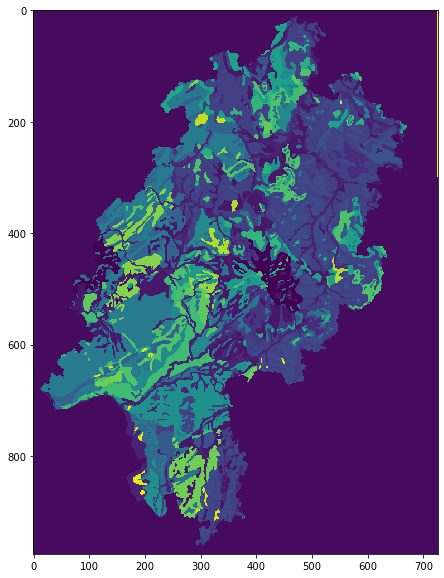

In [7]:
filepath = r'C:\Users\USER\Desktop\master-thesis-master\soil_map\results\great_hesse_soil_map_ref.tif'

#Load file in gdal
file = gdal.Open(filepath, gdal.GA_ReadOnly)

#Initialize an array of zeros with size of input
img = np.zeros((file.RasterYSize, file.RasterXSize, file.RasterCount), gdal_array.GDALTypeCodeToNumericTypeCode(file.GetRasterBand(1).DataType))

#Loop over the number of bands in the image (img.shape[2]) insert values into the numpy array
for b in range(img.shape[2]):
    img[ : , : , b] = file.GetRasterBand(b + 1).ReadAsArray()

#Reshape array 
new_shape = (img.shape[0] * img.shape[1], img.shape[2])

#based on this shape, we can build the input value
X = img[: , : , :3].reshape(new_shape)
#X = np.where(X==150, 255, X) Bad idea because other r ,g or b values may have same as black and gray
#X = np.where(X==0, 255, X) 

#Classifier Kmeans
k_means = cluster.KMeans(n_clusters=33)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

#Get statistic values
for i in np.unique(X_cluster):
    blobs = np.int_(morphology.binary_opening(X_cluster == i))
    color = np.around(k_means.cluster_centers_[i])
    count = len(np.unique(measure.label(blobs))) - 1
    print('Color: {}  >>  Objects: {}'.format(color, count))
    
#Plot the data
plt.figure(figsize=(20,10))
plt.imshow(X_cluster)

plt.show()


## Save Classification as GeoTiff 

In [ ]:
#Open input image again to get properties
file = gdal.Open(filepath)

#We need a single band
band = file.GetRasterBand(1)

#Convert it to an array
arr = band.ReadAsArray()

#Extract columns and rows to a list
[cols, rows] = arr.shape

#Set the output as Geotiff
format = "GTiff"
driver = gdal.GetDriverByName(format)

#Creates the output raster with the dimensions of the input raster
#outDataRaster = driver.Create("soil_map_hesse_classify_33.tiff", rows, cols, 1, gdal.GDT_Byte) -> activate this cell for saving image local

#Set the projection and extent of the data.
outDataRaster.SetGeoTransform(file.GetGeoTransform())##sets same geotransform as input
outDataRaster.SetProjection(file.GetProjection())##sets same projection as input

#Write classification result to a single band raster image 
outDataRaster.GetRasterBand(1).WriteArray(X_cluster)

#Calling FlushCache() to remove from memory and delete the data
outDataRaster.FlushCache() ## remove from memory
del outDataRaster ## delete the data (not the actual geotiff)

## Analyse Soil Types within AOI

In [76]:
#Load Soil Types from BÜK 1:500.000 and clip to AOI
soil_map_great = ee.Image('users/tillmueller1990/soil_map_hesse_classify_33').clip(ried_225_222)

#Mask out image 
mask = soil_map_great.neq(1) #Value 1 is invalid its the background (white) from screenshot 
soil_map_great = soil_map_great.updateMask(mask) #Apply Mask

#Correct raster values to corresponding soil class values 
soil_map_great = soil_map_great.where(soil_map_great.eq(14),1)
soil_map_great = soil_map_great.where(soil_map_great.eq(3),2)
soil_map_great = soil_map_great.where(soil_map_great.eq(31),3)
soil_map_great = soil_map_great.where(soil_map_great.eq(19),4)
soil_map_great = soil_map_great.where(soil_map_great.eq(8),5)
soil_map_great = soil_map_great.where(soil_map_great.eq(9),7)
soil_map_great = soil_map_great.where(soil_map_great.eq(0),8)
soil_map_great = soil_map_great.where(soil_map_great.eq(5),9)
soil_map_great = soil_map_great.where(soil_map_great.eq(12),34)


#Get Unique values to check if every value is signed correctly 
soil_map_great_uniqueValues = soil_map_great.reduceRegion(reducer=ee.Reducer.countDistinct(), geometry=soil_map_great.geometry(), scale= 100,maxPixels= 1e10)
print("soil_map_great_uniqueValues", soil_map_great_uniqueValues.getInfo())
print("soil_map_great_histogram", soil_map_great_histogram)

#Convert an image to a feature collection by reducing homogenous regions
soil_map_great_labeled = soil_map_great.connectedComponents(ee.Kernel.plus(1), 256)
features = soil_map_great_labeled.reduceToVectors(reducer = ee.Reducer.first(), geometry= soil_map_great.geometry(), scale= 100, geometryType= 'Polygon', eightConnected= False)
#print(features.getInfo())

#Create LookUp Table for raster values corresponding to the soil type 
soil_types_legend = {1:'Niedermoore, Hochmoore', 2:'Vega, Auengleye, örtl. Anmoorgleye', 3:'Tschernoseme', 4:'Parabraunerden', 5:'Braunerden mit Bändern, Bänder-Parabraunerden, örtl. Podsol-Braunerden', 7:'Pararendzinen, Braunerden mit Bändern, örtl. Bänder-Parabraunerden', 8:'Braunerden mit Bändern, Bänder-Parabraunerden, örtl. Podsol-Braunerden', 9:'Pararendzinen', 25: 'Braunerden, Ranker-Braunerden, Regosol-Braunerden' , 34 : 'Braunerden, Braunerde-Pseudogleye, örtl. Podsol-Braunerden'} #Legende
raster_value_soil_value = {14:1, 3:2, 31:3, 19:4, 8:5, 9:7 , 0:8, 5:9 } # Value in raster value of legend

class_areas = ee.Image.pixelArea().addBands(soil_map_great).reduceRegion(reducer= ee.Reducer.sum().group(groupField= 1,groupName= 'class'),geometry=soil_map_great.geometry(),scale= 100, maxPixels= 1e10).get('groups') # sample the geometry at 1m intervals;
#print("class_areas",class_areas.getInfo())

#create basemap
map_s = Map(center = center, zoom = zoom, basemap=basemaps.Esri.NatGeoWorldMap)
#add Layer to map
soil_map_great_viz = GetTileLayerUrl(soil_map_great.visualize()) #Create GeoJSON ipyleaflet object
soil_map_great_layer = ipyleaflet.TileLayer(url=soil_map_great_viz,name='soil_map_great')

soil_map_great_patches_viz = GetTileLayerUrl(features.draw(color= '006600').visualize())
soil_map_great_patches_layer = ipyleaflet.TileLayer(url=soil_map_great_patches_viz, name='soil_class features')

map_s.add_layer(soil_map_great_layer) #add layer to map
map_s.add_layer(soil_map_great_patches_layer) #add layer to map

#display map
map_s.add_control(LayersControl())
map_s



soil_map_great_uniqueValues {'b1': 10}
soil_map_great_histogram [[1.0, 5417.066666666666], [2.0, 16757.592156862796], [3.0, 3229.0], [4.0, 17947.180392156875], [5.0, 0.0], [6.0, 0.0], [7.0, 8856.82352941177], [8.0, 5301.596078431373], [9.0, 13167.066666666684], [10.0, 0.0], [11.0, 0.0], [12.0, 0.0], [13.0, 0.0], [14.0, 0.0], [15.0, 0.0], [16.0, 0.0], [17.0, 0.0], [18.0, 0.0], [19.0, 0.0], [20.0, 0.0], [21.0, 0.0], [22.0, 0.0], [23.0, 0.0], [24.0, 0.0], [25.0, 1755.694117647058], [26.0, 0.0], [27.0, 0.0], [28.0, 0.0], [29.0, 0.0], [30.0, 0.0], [31.0, 0.0], [32.0, 0.0], [33.0, 0.0], [34.0, 108.71372549019608]]


Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{…

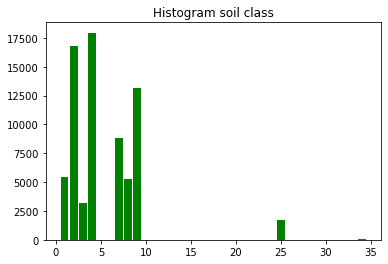

In [77]:
histogram_soil_map_great = get_histogram_from_image(soil_map_great)

plt.bar(histogram_soil_map_great.keys(), histogram_soil_map_great.values(), color='g')
plt.title("Histogram soil class")
plt.show()

In [69]:
#ried_viz = GetTileLayerUrl(ried_225_222.visualize())
#In order to analyse the soil-moisture content we need to know more about the landuse and landcover. We are interested in fields with less or no vegetation.   
#Grouped a count reducer: count number of land cover category pixels by patches
print(soil_map_great_labeled.bandNames().getInfo())
count = soil_map_great_labeled.select(['labels','b1']).reduceRegion(reducer= ee.Reducer.count().group(groupField= 0, groupName= 'patch id'), geometry= ried_geometry, scale= 100,  maxPixels= 1e8)
print(count.getInfo())

['labels', 'b1']
{'groups': [{'count': 503, 'patch id': 2005749729182}, {'count': 6766, 'patch id': 2005749729185}, {'count': 7, 'patch id': 2010044696476}, {'count': 127, 'patch id': 2014339663770}, {'count': 200, 'patch id': 2104533977025}, {'count': 519, 'patch id': 2130303780806}, {'count': 467, 'patch id': 2207613192426}, {'count': 3164, 'patch id': 2211908159388}, {'count': 1560, 'patch id': 2220498093978}, {'count': 6, 'patch id': 2220498094266}, {'count': 550, 'patch id': 2229088028633}, {'count': 2006, 'patch id': 2263447767181}, {'count': 552, 'patch id': 2263447767223}, {'count': 852, 'patch id': 2276332669101}, {'count': 6568, 'patch id': 2319282341985}, {'count': 46, 'patch id': 2357937047494}, {'count': 716, 'patch id': 2357937047502}, {'count': 68, 'patch id': 2366526982102}, {'count': 7555, 'patch id': 2392296786053}, {'count': 488, 'patch id': 2448131360856}, {'count': 98, 'patch id': 2456721295578}, {'count': 1, 'patch id': 2478196132177}, {'count': 9, 'patch id': 252